In [49]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
## Seeding 
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [50]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    up=keras.layers.UpSampling2D((2,2))

    f_bn= up(up(up(up(bn))))
    f_u1=up(up(up(u1)))
    f_u2=up(up(u2))
    f_u3=up(u3)
    deep_supervised = keras.layers.Concatenate()([f_bn,f_u1,f_u2,f_u3,u4])
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(deep_supervised)
    model = keras.models.Model(inputs, outputs)
    return model

In [17]:
"""tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=24
)"""

'tf.keras.utils.plot_model(\n    model,\n    to_file="model.png",\n    show_shapes=True,\n    \n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=24\n)'

In [6]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

In [7]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))

print(len(train_data))

54


In [8]:

# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [10]:
def data_gen(x_path_list,y_path_list,batch_size=3):
  """
  Return batches of input image and segmentaion mask 
  """  
  train_batch = np.zeros(shape = (3, 512, 512, 3));
  
  train_label = np.zeros(shape = (3, 512, 512, 1));
  counter=0
  skipped=0
  while True :
    
    #image
    train_batch[0, :, :,:] = resize(imread(x_path_list[counter+skipped]), (512, 512))
    #label
    if x_path_list[counter+skipped][-6:-4]==y_path_list[counter][-9:-7]:
      img = cv2.cvtColor(imread(y_path_list[counter]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      train_label[0, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
      
      #flip
      train_batch[1, :, :,:]=np.flip(train_batch[0, :, :,:],axis=1)
      train_label[1, :, :,:]=np.flip(train_label[0, :, :,:],axis=1)
      #rotate
      train_batch[2, :, :,:]=np.rot90(np.rot90(train_batch[0, :, :,:]))
      train_label[2, :, :,:]=np.rot90(np.rot90(train_label[0, :, :,:]))
      train_batch/=255
      train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
      mask = train_label[:,:,:,:] > 0.3
      train_label[mask] = 1.0
      train_label[~mask] = 0.0
      yield train_batch,train_label
      counter+=1
    else:
      skipped+=1
      
    
    if counter>=len(y_path_list):
      counter=0
      skipped=0
gen=data_gen(train_data,train_data_gt[0])

In [11]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))   

In [12]:
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


## train data

In [13]:
train_batch = np.zeros(shape = (len(train_data)*3, 512, 512, 3));
train_label = np.zeros(shape = (len(train_data)*3, 512, 512, 1));

for file_index in range(0,len(train_data)*3,3):
    #print(file_index)
    # image
    train_batch[file_index, :, :,:] = resize(imread(train_data[int(file_index/3)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(train_data_gt[2][int(file_index/3)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    train_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #rotate
    train_batch[file_index+2, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+2, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/255# - train_images[:,:,:,0].min(axis=0)) / (train_images[:,:,:,0].max(axis=0) - train_images[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/255# - train_images[:,:,:,1].min(axis=0)) / (train_images[:,:,:,1].max(axis=0) - train_images[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/255# - train_images[:,:,:,2].min(axis=0)) / (train_images[:,:,:,2].max(axis=0) - train_images[:,:,:,2].min(axis=0)+1e-10)

train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.3
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(162, 512, 512, 3)
(162, 512, 512, 1)


## test data

In [14]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
#test_labels_ls=[]
test_label = np.zeros(shape = (len(test_data), 512, 512, 1));

for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512, 512))
    # label
    img = cv2.cvtColor(imread(test_data_gt[2][int(file_index)]), cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

test_batch  = test_batch/255

test_label[:,:,:,0]  = (test_label[:,:,:,0] - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)

mask = test_label[:,:,:,:] > 0.3
test_label[mask] = 1.0
test_label[~mask] = 0.0

print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


In [32]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

In [61]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size=512
opt=keras.optimizers.Adam(learning_rate = 0.002,beta_1=0.8)
model = UNet()
model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.MeanIoU(num_classes=2)])   

In [52]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, 512, 512, 3)  84          input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 512, 512, 3)  12          conv2d_195[0][0]                 
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 512, 512, 3)  84          batch_normalization_190[0][0]    
______________________________________________________________________________________

In [62]:
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=10)
#rlrop=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3) 
gen=data_gen(train_data,train_data_gt[2])
#hist = model.fit(gen, steps_per_epoch=len(train_data_gt[2]), epochs = 100, verbose = 2, callbacks=[early_stopping], shuffle = True)
hist = model.fit(x = train_batch, y = train_label, batch_size = 2, epochs = 200, verbose = 1, callbacks=[early_stopping], validation_split = 8/150, shuffle = True)

Epoch 1/200
77/77 [==============================] - 12s 159ms/step - loss: 0.9408 - auc_7: 0.8066 - mean_io_u_7: 0.5168 - val_loss: 0.9981 - val_auc_7: 0.4495 - val_mean_io_u_7: 0.4997
Epoch 2/200
77/77 [==============================] - 11s 145ms/step - loss: 0.8357 - auc_7: 0.7679 - mean_io_u_7: 0.5617 - val_loss: 0.9976 - val_auc_7: 0.7564 - val_mean_io_u_7: 0.4997
Epoch 3/200
77/77 [==============================] - 11s 146ms/step - loss: 0.6965 - auc_7: 0.7673 - mean_io_u_7: 0.5701 - val_loss: 0.9957 - val_auc_7: 0.4997 - val_mean_io_u_7: 0.4997
Epoch 4/200
77/77 [==============================] - 11s 145ms/step - loss: 0.5864 - auc_7: 0.7884 - mean_io_u_7: 0.5537 - val_loss: 0.9928 - val_auc_7: 0.4999 - val_mean_io_u_7: 0.4997
Epoch 5/200
77/77 [==============================] - 11s 144ms/step - loss: 0.5475 - auc_7: 0.8012 - mean_io_u_7: 0.5432 - val_loss: 0.9930 - val_auc_7: 0.5000 - val_mean_io_u_7: 0.4997
Epoch 6/200
77/77 [==============================] - 11s 145ms/step - 

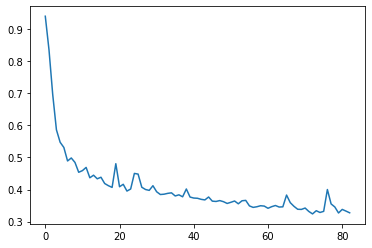

In [63]:
 plt.plot(hist.history['loss'])

## prediction


(512, 512, 1)


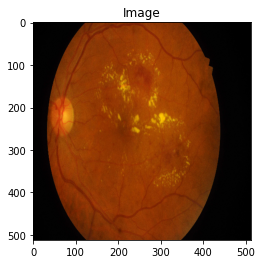

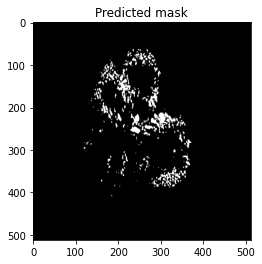

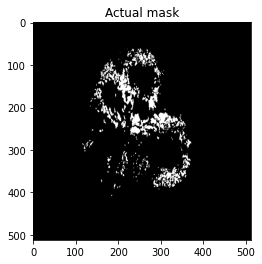

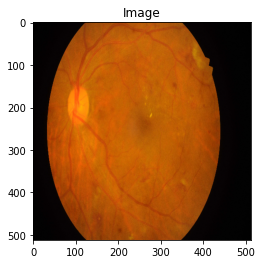

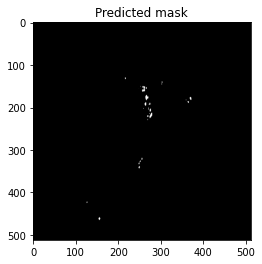

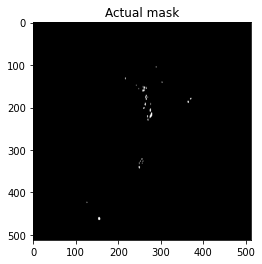

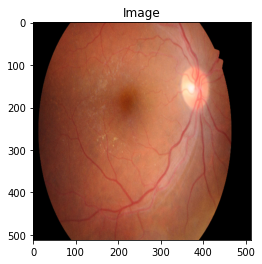

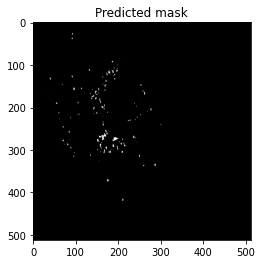

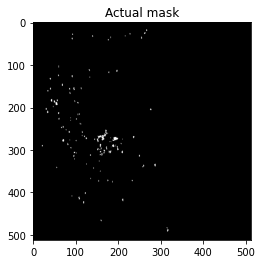

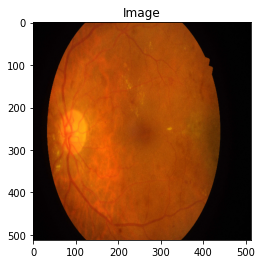

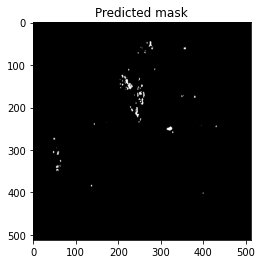

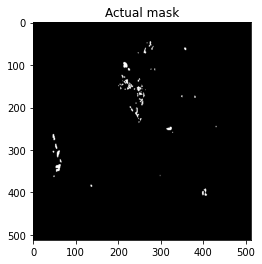

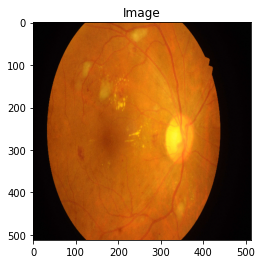

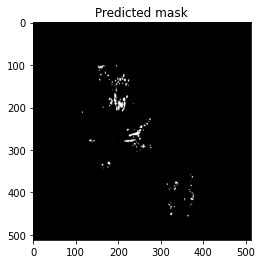

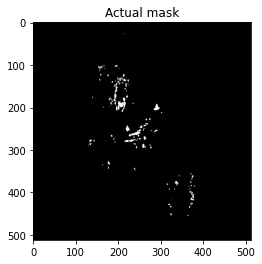

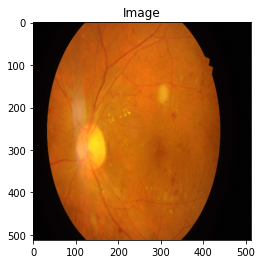

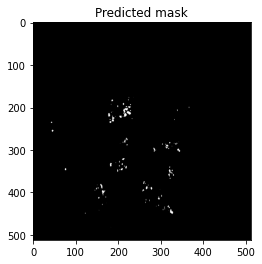

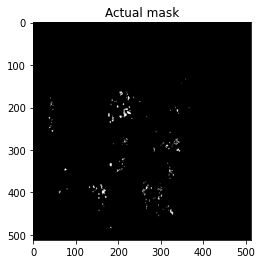

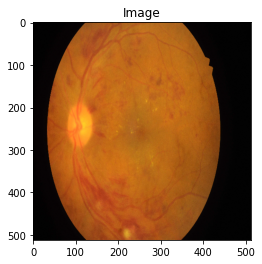

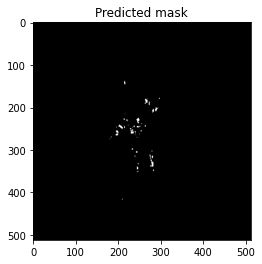

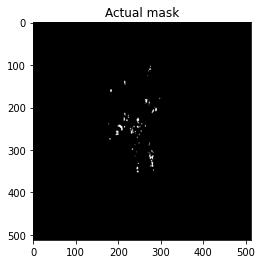

In [64]:
predicted_test_label=model.predict(test_batch)
print(predicted_test_label[0].shape)
for i in range(7):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

In [65]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
#train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
print("train ",0," test ",test_auc)

train  0  test  0.9394883842722946


In [66]:
from sklearn.metrics import f1_score
testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
test_f1 = f1_score(testy, yhat_classes)
#testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
#train_f1 = f1_score(testy, yhat_classes)
train_f1=0
print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

Train  F1 score: 0.000000 Test F1 score: 0.714860


In [69]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
#train_aupr = precision_recall_curve(train_label.reshape(-1),predicted_train_label.reshape(-1))
#train_auc=auc(train_aupr[1],train_aupr[0] )
train_auc=0
test_auc=auc(test_aupr[1],test_aupr[0] )
print("train AUPR",train_auc," test AUPR",test_auc)

train AUPR 0  test AUPR 0.7343746979270434


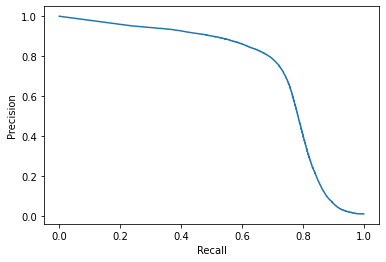

In [71]:
plt.plot(test_aupr[1],test_aupr[0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()